<a href="https://colab.research.google.com/github/ReuelNixon/Proompts-NextJS/blob/main/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False,
    transform = ToTensor(),
    download = True
)

In [3]:
image, label = train_data[0]
# image, label =  train_data.data[0], train_data.targets[0]
# Both are similar
label, image

(9,
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.00

In [4]:
image.size()

torch.Size([1, 28, 28])

By checking out the size, we can infer the following
`[color_channels=1, height=28, width=28]`


In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
classes = train_data.classes

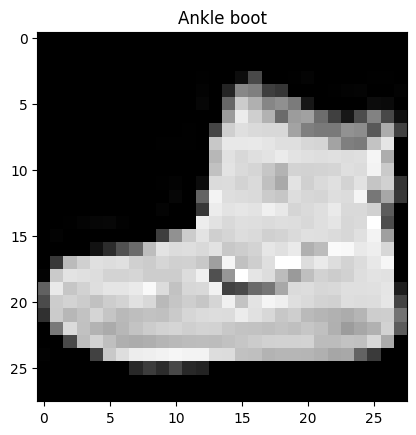

In [7]:
plt.imshow(image.squeeze(), cmap='gray');
plt.title(classes[label]);

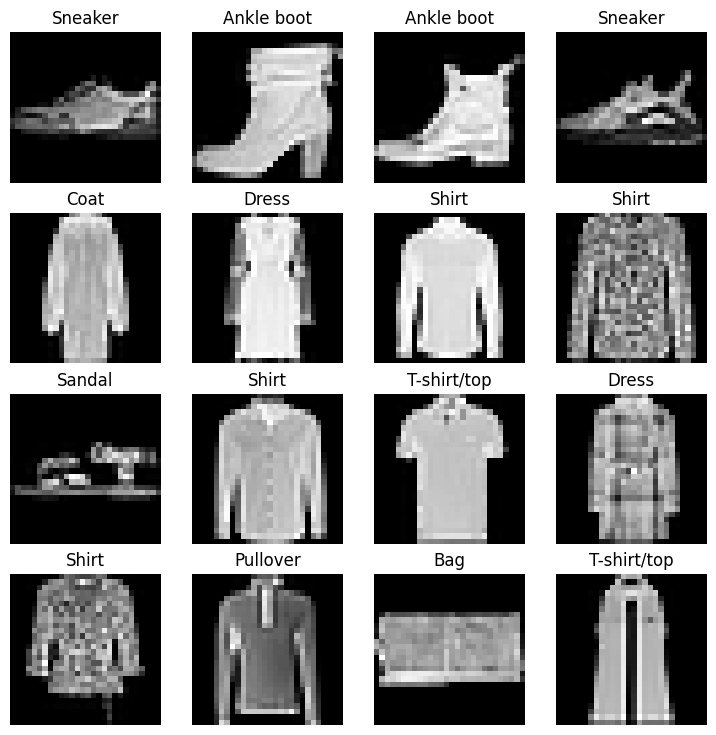

In [8]:
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_index = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray');
  plt.title(classes[label]);
  plt.axis(False)

In [9]:
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle = True
)

len(train_dataloader), test_dataloader

(1875, <torch.utils.data.dataloader.DataLoader at 0x7ec5f17a2230>)

In [10]:
imgs, labels = next(iter(train_dataloader))
imgs.size(), labels.size()

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
flatten = nn.Flatten()
flattened_image = flatten(image)
flattened_image.size()

torch.Size([1, 784])

In [12]:
class FashionModelV0(nn.Module):
  def __init__(self, input_features, output_features, intermediate_features):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features, out_features=intermediate_features),
        nn.Linear(in_features=intermediate_features, out_features=output_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [13]:
model0 = FashionModelV0(
    input_features = 784,
    intermediate_features = 10,
    output_features = 10
).to('cpu')

In [14]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [15]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.1)

In [16]:
%%time
epochs = 4
for epoch in range(epochs):
  print(f"Epoch: {epoch}")
  print("------")
  train_loss = 0

  for batch, (X, y) in enumerate(train_dataloader):
    model0.train()

    y_preds = model0(X)

    loss = loss_fn(y_preds, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)


  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      test_preds = model0(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_preds.argmax(dim = 1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.3f}\tTest loss: {test_loss}\tTest acc: {test_acc}\n\n")

Epoch: 0
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train loss: 0.593	Test loss: 0.5361444354057312	Test acc: 81.31988817891374


Epoch: 1
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train loss: 0.479	Test loss: 0.6284818649291992	Test acc: 76.99680511182109


Epoch: 2
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train loss: 0.458	Test loss: 0.4714435040950775	Test acc: 83.66613418530352


Epoch: 3
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train loss: 0.445	Test loss: 0.4831306040287018	Test acc: 83.47643769968052




In [17]:
def evaluate(model, data_loader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      test_preds = model(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_preds.argmax(dim = 1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__,
      "model_loss": test_loss.item(),
      "model_acc": test_acc
  }

In [18]:
model0_results = evaluate(model0, test_dataloader, loss_fn, accuracy_fn)
model0_results

{'model_name': 'FashionModelV0',
 'model_loss': 0.48266366124153137,
 'model_acc': 83.47643769968052}

### Writing device agnostic code and functionizing the train loop

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [20]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  model.to(device)

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    train_preds = model(X)

    loss = loss_fn(train_preds, y)

    train_acc += accuracy_fn(y_true=y, y_pred=train_preds.argmax(dim = 1))
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 500 == 0:
      print(f"Finished training on  {batch * len(X)} / {len(data_loader.dataset)} samples")

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.3f}\tTrain accuracy: {train_acc:.3f}")


def test_step(model, data_loader, loss_fn, accuracy_fn, device):
  model.to(device)

  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      test_preds = model(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_preds.argmax(dim = 1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.3f}\Test accuracy: {test_acc:.3f}")

In [21]:
class FashionModelV1(nn.Module):
  def __init__(self, input_features, intermediate_features, output_features):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_features, out_features = intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features = intermediate_features, out_features = output_features),
        nn.ReLU()
    )

  def forward(self,X):
    return self.layer_stack(X)

In [22]:
model1 = FashionModelV1(input_features=784, intermediate_features=10, output_features=10).to(device)

In [23]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [24]:
%%time
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    print("---------")

    train_step(
        model = model1,
        data_loader = train_dataloader,
        optimizer = optimizer,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device
    )

    test_step(
        model = model1,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device
    )

Epoch: 0
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  32000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.655	Train accuracy: 76.895
Test loss: 0.579\Test accuracy: 78.864
Epoch: 1
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  32000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.481	Train accuracy: 82.915
Test loss: 0.488\Test accuracy: 82.248
Epoch: 2
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  32000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.448	Train accuracy: 83.980
Test loss: 0.539\Test accuracy: 80.451
CPU times: user 32.3 s, sys: 106 ms, total: 32.4 s
Wall time: 32.7 s


In [25]:
def evaluate(model, data_loader, loss_fn, accuracy_fn, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)
      test_preds = model(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_preds.argmax(dim = 1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__,
      "model_loss": test_loss.item(),
      "model_acc": test_acc
  }

In [26]:
model1_results = evaluate(model1, test_dataloader, loss_fn, accuracy_fn, device)
model1_results

{'model_name': 'FashionModelV1',
 'model_loss': 0.5398349761962891,
 'model_acc': 80.45127795527156}

In [27]:
from torch.nn.modules import MaxPool2d
class FashionModelV2(nn.Module):
  def __init__(self, input_features, output_features, intermediate_features):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_features,
            out_channels = intermediate_features,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU()
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(
            in_channels = intermediate_features,
            out_channels = intermediate_features,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )

    self.block3 = nn.Sequential(
        nn.Conv2d(
            in_channels = intermediate_features,
            out_channels = intermediate_features,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU()
    )

    self.block4 = nn.Sequential(
        nn.Conv2d(
            in_channels = intermediate_features,
            out_channels = intermediate_features,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = intermediate_features*7*7,
            out_features=output_features
        )
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.classifier(x)
    return x

In [28]:
model2 = FashionModelV2(
    input_features = 1,
    intermediate_features = 10,
    output_features = 10
).to(device)

In [29]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2.parameters(), lr = 0.1)

In [30]:
%%time

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Epoch: 0
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  32000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.554	Train accuracy: 79.778
Test loss: 0.376\Test accuracy: 86.252
Epoch: 1
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.350	Train accuracy: 87.420
Test loss: 0.335\Test accuracy: 87.590
Epoch: 2
---------
Finished training on  0 / 60000 samples
Finished training on  16000 / 60000 samples
Finished training on  32000 / 60000 samples
Finished training on  48000 / 60000 samples
Train loss: 0.310	Train accuracy: 88.883
Test loss: 0.327\Test accuracy: 88.189
CPU times: user 2min 39s, sys: 446 ms, total: 2min 39s
Wall time: 2min 42s


In [31]:
model2_results = evaluate(model2, test_dataloader, loss_fn, accuracy_fn, device)
model2_results

{'model_name': 'FashionModelV2',
 'model_loss': 0.32704660296440125,
 'model_acc': 88.18889776357827}

In [32]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [33]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [34]:
pred_probs= make_predictions(model=model2,data=test_samples)

In [35]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([5, 5, 8, 4, 6, 2, 0, 9, 0]), [5, 5, 8, 6, 8, 2, 0, 9, 0])

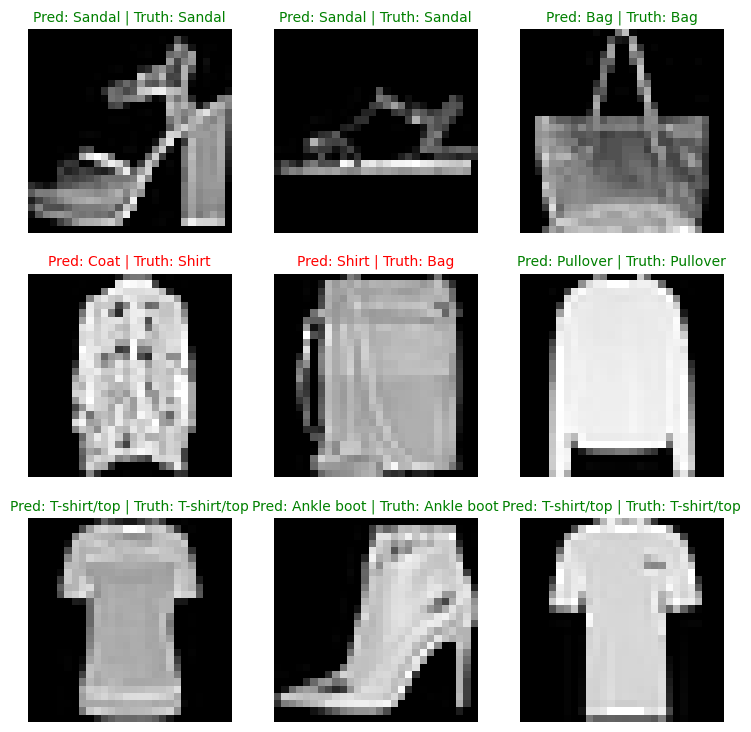

In [36]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = classes[pred_classes[i]]
  truth_label = classes[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [37]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [38]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.22.0


In [39]:
y_preds = []
y_true = []
model2.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
    y_true.append(y.cpu())
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

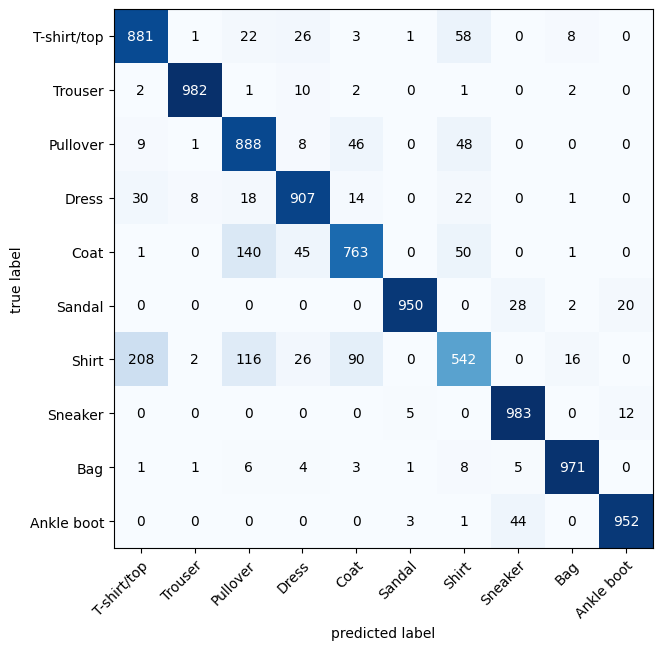

In [40]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(classes), task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor, target = y_true_tensor)

fig, ax = plot_confusion_matrix(
  conf_mat = confmat_tensor.numpy(),
  class_names=classes,
  figsize=(10, 7)
)

In [41]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(
  parents=True,
  exist_ok=True
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model2.state_dict(),
    f=MODEL_SAVE_PATH
)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [42]:
loaded_model_2 = FashionModelV2(
  input_features = 1,
  intermediate_features = 10,
  output_features = 10
)

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2 = loaded_model_2.to(device)

In [43]:
loaded_model_2_results = evaluate(
  model=loaded_model_2,
  data_loader=test_dataloader,
  loss_fn=loss_fn,
  accuracy_fn=accuracy_fn,
  device = device
)

loaded_model_2_results, model2_results

({'model_name': 'FashionModelV2',
  'model_loss': 0.32746708393096924,
  'model_acc': 88.17891373801918},
 {'model_name': 'FashionModelV2',
  'model_loss': 0.32704660296440125,
  'model_acc': 88.18889776357827})